# CNN-TDA Net Tutorial: HMNIST Classification
In this tutorial, we will introduce how to use `cnntdanet` package to solve pigmented lesion classification. We note that our package are not released yet and we are still building and documenting. We will release our package as soon as possible.

## 1. Setting

In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

We provide `seed_all` utility function that can control randomness throughout this program, allowing us to obtain the same results whenever we run the code. This step requires `TensorFlow > 2.8.0` for `tf.config.experimental.enable_op_determinism()`.

In [2]:
from cnntdanet.utils import seed_all

seed = 0
seed_all(seed)

## 2. Loading HMNIST dataset
The dataset is available at [https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000](https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000). The dataset consists of 10,015 dermatoscopic images each
of which is labeled with one of seven different diagnostic categories.

In [3]:
df = pd.read_csv('../datasets/skin-cancer/hmnist_28_28_L.csv')

X = df.drop('label', axis=1).values.reshape((-1, 28, 28, 1))
y = df['label'].values

X = X.astype(np.float32)
X /= 255.0

y = y.astype(np.int64)

print("The number of data: ", len(X))
display(pd.value_counts(df['label']))

The number of data:  10015


4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: label, dtype: int64

`cnntdanet` has many utility functions for visualization, so you can quickly explore and analyze data. The following codes visualizes 16 data that are chosen at random.

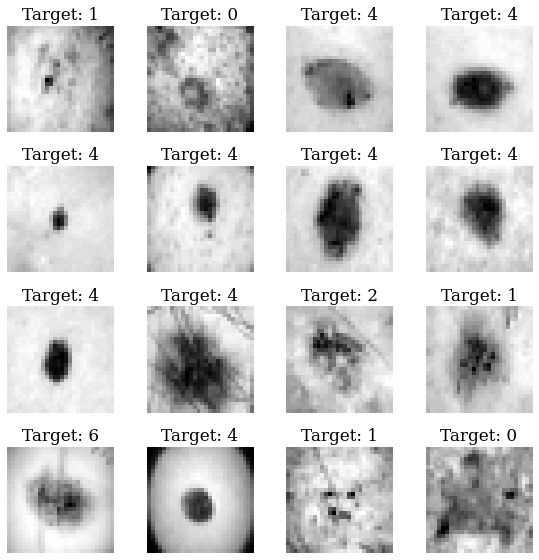

In [4]:
from cnntdanet.utils.plotting import visualize_image_samples

# The number of random samples
N = 16

# Choose random indices
sample_indices = np.random.choice(a=range(len(X)), size=16)

# Take samples
samples = X[sample_indices]
target = y[sample_indices]

visualize_image_samples(samples, y[sample_indices], scale=2)

## 3. Create topological features
`cnntdanet` use `giotto-tda` to create topological features. We predefined some of `gtda.pipeline.Pipeline`s for persistence image, persistence landscape, and betti-curve, which allow you to easily create topological features even though you are not familar with TDA.

<br>

(Optional) If you are familar with `giotto-tda`, of course, you can use your own tda pipeline by using `gtda.pipeline.Pipeline`.

In [5]:
from cnntdanet.tda import get_tda_pipeline

# The method name should be one of ['persistence-image', 'persistence-landscape', 'betti-curve']
method = 'persistence-landscape'

# For each method, you should define some required arguments.
n_bins = 100
n_layers=1

# Build a gtda.pipeline.Pipeline
pipeline = get_tda_pipeline(method=method, n_bins=n_bins, n_layers=n_layers)

##########
# or You can define your own pipeline
# pipeline = Pipeline([('diagram', CubicalPersistence(homology_dimensions=[0, 1], n_jobs=-1)),
#                      ('Scaler', Scaler(n_jobs=-1)),
#                      ('Vectorization', BettiCurve(n_jobs=-1)),
#                      ('Reshape', ChannelLast())])
#########

print(pipeline)

Pipeline(steps=[('Diagram',
                 CubicalPersistence(homology_dimensions=[0, 1], n_jobs=-1)),
                ('Scaler', Scaler(n_jobs=-1)),
                ('Vectorization', PersistenceLandscape(n_jobs=-1)),
                ('Reshape', ChannelLast())])


One can obtain topological features by feeding our data into `pipeline.fit_transform`

In [6]:
X_tda = pipeline.fit_transform(X)
X_tda = X_tda.astype(np.float32)

print(X_tda.shape)

(10015, 100, 2)


Let's visualize a sample with a topological vector.

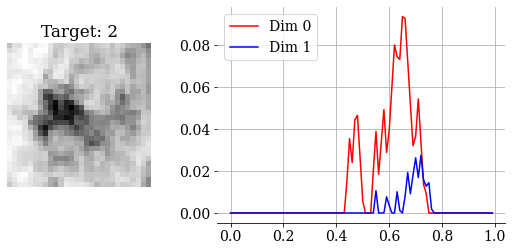

In [7]:
# The number of random samples
N = 1

# Choose random indices
sample_indices = np.random.choice(a=range(len(X)), size=N)

# Take samples
img = X[sample_indices]
tda = X_tda[sample_indices]
label = y[sample_indices]

# Visualization
fig= plt.figure(figsize=(8, 5))

ax_img = fig.add_axes([0.01, 0.3, 0.4, 0.4])
ax_img.imshow(img[0], cmap='gray'); ax_img.axis('off'); ax_img.set_title(f"Target: {label[0]}")

ax_tda = fig.add_axes([0.45, 0.2, 0.5, 0.6])
filts = np.arange(len(tda[0])) / len(tda[0])
ax_tda.plot(filts, tda[0, :, 0], 'r-', label="Dim 0")
ax_tda.plot(filts, tda[0, :, 1], 'b-', label="Dim 1")
ax_tda.grid(); ax_tda.legend();
ax_tda.spines['top'].set_visible(False)
ax_tda.spines['left'].set_visible(False)
ax_tda.spines['right'].set_visible(False)

plt.show(fig)

## 4. Modeling
- Before moving to modeling part, let divide our dataset into a training and a validation dataset.

In [8]:
y_ = y.copy()

In [9]:
from sklearn.model_selection import train_test_split
train_indices, valid_indices = train_test_split(np.arange(len(X)), stratify=y_, test_size=0.2, random_state=seed)

# One-hot encoding
n_classes = 7
y = tf.keras.utils.to_categorical(y_, n_classes) 

X_img_train, X_tda_train, y_train = X[train_indices], X_tda[train_indices], y[train_indices]
X_img_valid, X_tda_valid, y_valid = X[valid_indices], X_tda[valid_indices], y[valid_indices]

### 2D CNN
We also provide predefined 1D- and 2D-CNN, which are WaveNet and O'TRAIN, respectively. One can build a O'TRAIN as follows:

In [10]:
from cnntdanet.models import get_cnn_net, get_cnn_tda_net

input_shape = (28, 28, 1) 
n_classes = 7

# Build a single 2D-CNN network
cnn = get_cnn_net(input_shape=input_shape, n_classes=n_classes)
# Define a loss function, an optimization method, and evaluate metrics
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
# Train the model
history = cnn.fit(
    X_img_train, y_train,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
    epochs=20
)

Epoch 1/20
201/201 [==============================] - 6s 10ms/step - loss: 1.1799 - acc: 0.6634 - val_loss: 1.1453 - val_acc: 0.6862
Epoch 2/20
201/201 [==============================] - 2s 8ms/step - loss: 1.0846 - acc: 0.6653 - val_loss: 0.9761 - val_acc: 0.6862
Epoch 3/20
201/201 [==============================] - 2s 8ms/step - loss: 1.0209 - acc: 0.6655 - val_loss: 0.9148 - val_acc: 0.6968
Epoch 4/20
201/201 [==============================] - 2s 8ms/step - loss: 0.9663 - acc: 0.6764 - val_loss: 1.0768 - val_acc: 0.6744
Epoch 5/20
201/201 [==============================] - 2s 8ms/step - loss: 0.9361 - acc: 0.6833 - val_loss: 0.9095 - val_acc: 0.7012
Epoch 6/20
201/201 [==============================] - 2s 8ms/step - loss: 0.9096 - acc: 0.6859 - val_loss: 0.8303 - val_acc: 0.7218
Epoch 7/20
201/201 [==============================] - 2s 8ms/step - loss: 0.8838 - acc: 0.6964 - val_loss: 0.8324 - val_acc: 0.7118
Epoch 8/20
201/201 [==============================] - 2s 8ms/step - loss: 0

We also have an utility function for plotting a learning curve.

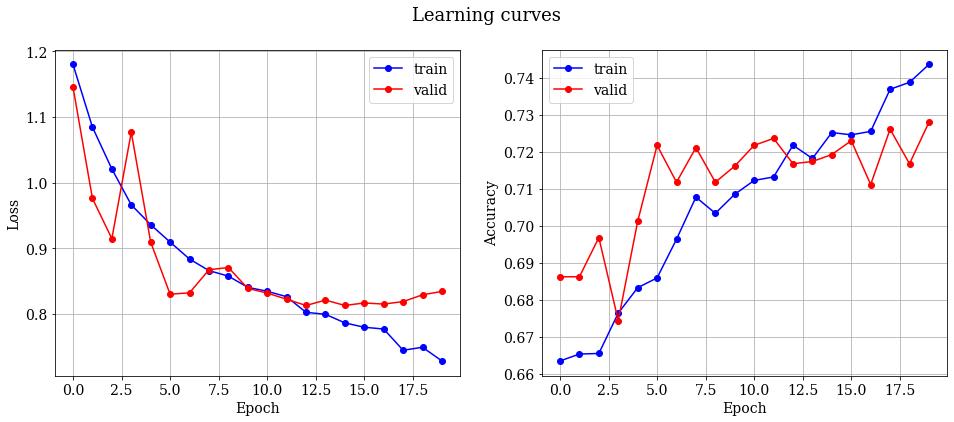

In [11]:
from cnntdanet.utils.plotting import plot_learning_curve

plot_learning_curve(history.history, dir_save=None)

Let evaluate the 2D-CNN on the test data

In [12]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
y_true = np.argmax(y_valid, axis=1) # From one-hot encoding to label
y_pred = cnn.predict(X_img_valid)  # Make predictions
y_pred = np.argmax(y_pred, axis=1)  # Take the maximum probability for each prediction

print(f"Accuracy  : {100 * accuracy_score(y_true, y_pred):.2f}")
print(f"Recall    : {100 * recall_score(y_true, y_pred, average='macro'):.2f}")
print(f"Precision : {100 * precision_score(y_true, y_pred, average='weighted', zero_division=0):.2f}")
print(f"F1        : {100 * f1_score(y_true, y_pred, average='weighted', zero_division=0):.2f}")

Accuracy  : 71.44
Recall    : 27.81
Precision : 66.38
F1        : 67.42


### CNN-PL Net
CNN-PL Net can be defined and trained as follows

In [13]:
method = 'persistence-landscape'
input_shape = {'img': (28, 28, 1), 'tda': (n_bins, 2)}
n_classes = 7

# Build a single 2D-CNN network
cnn_tda = get_cnn_tda_net(method=method, input_shape=input_shape, n_classes=n_classes)
# Define a loss function, an optimization method, and evaluate metrics
cnn_tda.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
# Train the model
history = cnn_tda.fit(
    [X_img_train, X_tda_train], y_train,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
    epochs=20
)

Epoch 1/20
201/201 [==============================] - 5s 19ms/step - loss: 1.0847 - acc: 0.6606 - val_loss: 1.2861 - val_acc: 0.6862
Epoch 2/20
201/201 [==============================] - 4s 18ms/step - loss: 0.9809 - acc: 0.6711 - val_loss: 0.9473 - val_acc: 0.6862
Epoch 3/20
201/201 [==============================] - 4s 20ms/step - loss: 0.9214 - acc: 0.6817 - val_loss: 0.8534 - val_acc: 0.7056
Epoch 4/20
201/201 [==============================] - 4s 19ms/step - loss: 0.9120 - acc: 0.6845 - val_loss: 0.9829 - val_acc: 0.6925
Epoch 5/20
201/201 [==============================] - 4s 18ms/step - loss: 0.9000 - acc: 0.6897 - val_loss: 0.8481 - val_acc: 0.7137
Epoch 6/20
201/201 [==============================] - 4s 18ms/step - loss: 0.8784 - acc: 0.6971 - val_loss: 0.8469 - val_acc: 0.7137
Epoch 7/20
201/201 [==============================] - 4s 18ms/step - loss: 0.8719 - acc: 0.6964 - val_loss: 0.8446 - val_acc: 0.7118
Epoch 8/20
201/201 [==============================] - 4s 19ms/step - 

The learning curve is shown below.

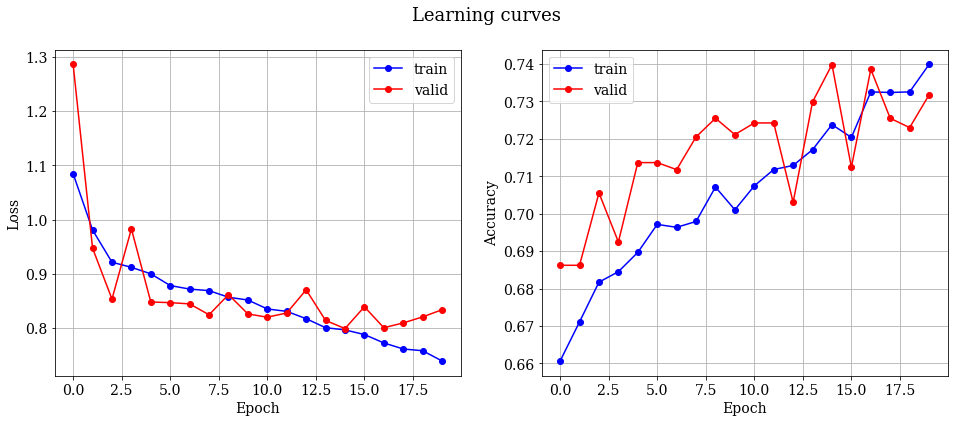

In [14]:
plot_learning_curve(history.history, dir_save=None)

Let evaluate the CNN-PL Net on the test data

In [15]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
y_true = np.argmax(y_valid, axis=1) # From one-hot encoding to label
y_pred = cnn_tda.predict([X_img_valid, X_tda_valid])  # Make predictions
y_pred = np.argmax(y_pred, axis=1)  # Take the maximum probability for each prediction

print(f"Accuracy  : {100 * accuracy_score(y_true, y_pred):.2f}")
print(f"Recall    : {100 * recall_score(y_true, y_pred, average='macro'):.2f}")
print(f"Precision : {100 * precision_score(y_true, y_pred, average='weighted', zero_division=0):.2f}")
print(f"F1        : {100 * f1_score(y_true, y_pred, average='weighted', zero_division=0):.2f}")

Accuracy  : 71.49
Recall    : 31.75
Precision : 67.94
F1        : 68.61


## 5. Grad-CAM Analysis
We also provide [Grad-CAM](https://arxiv.org/abs/1610.02391) analysis for a CNN and a CNN-TDA Net, which allows you to analyze what features our model extracts.

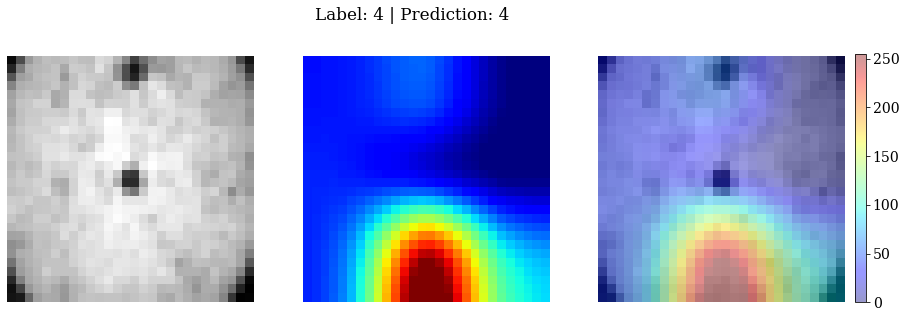

In [16]:
from cnntdanet.gradcam import GradCAMOnCNN

idx = 22
img = X_img_valid[idx:idx+1]
label = np.argmax(y_valid, axis=1)[idx]

gradcam_cnn = GradCAMOnCNN(cnn, layer_name='conv2d_4')
gradcam_cnn.to_heatmap(img, true_label=label)
gradcam_cnn.visualize()

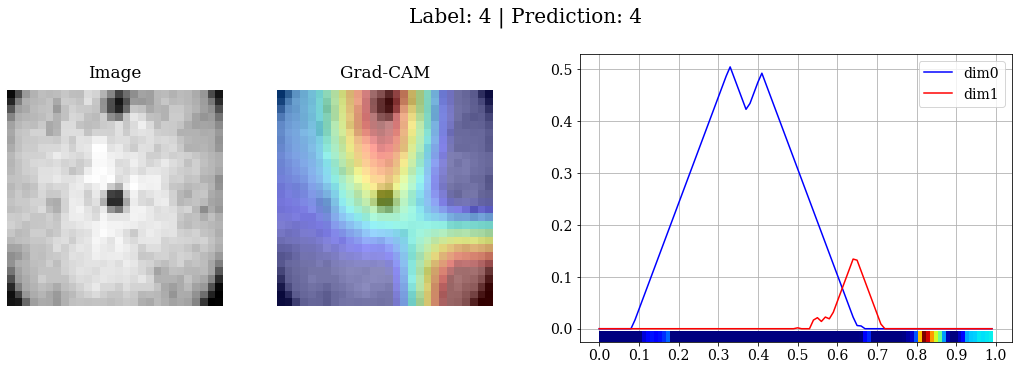

In [17]:
from cnntdanet.gradcam import GradCAMOnCNNTDANet

idx = 22
img = X_img_valid[idx:idx+1]
tda = X_tda_valid[idx:idx+1]
label = np.argmax(y_valid, axis=1)[idx]

gradcam_cnn_tda = GradCAMOnCNNTDANet(cnn_tda, local_layer_name='conv2d_9', global_layer_name='conv1d_8')
gradcam_cnn_tda.to_heatmap([img, tda], true_label=label)
gradcam_cnn_tda.visualize()